# Reference
https://towardsdatascience.com/data-augmentation-compilation-with-python-and-opencv-b76b1cd500e0

https://github.com/usmanr149/Yolo_bbox_manipulation

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Utility function
- yoloFormattocv
- cvFormattoYolo
- train_test_split

In [ ]:
#convert from Yolo_mark to opencv format
def yoloFormattocv(x1, y1, x2, y2, H, W):
    bbox_width = x2 * W
    bbox_height = y2 * H
    center_x = x1 * W
    center_y = y1 * H

    voc = []

    voc.append(center_x - (bbox_width / 2))
    voc.append(center_y - (bbox_height / 2))
    voc.append(center_x + (bbox_width / 2))
    voc.append(center_y + (bbox_height / 2))

    return [int(v) for v in voc]

# convert from opencv format to yolo format
# H,W is the image height and width
def cvFormattoYolo(corner, H, W):
    bbox_W = corner[3] - corner[1]
    bbox_H = corner[4] - corner[2]

    center_bbox_x = (corner[1] + corner[3]) / 2
    center_bbox_y = (corner[2] + corner[4]) / 2

    return corner[0], round(center_bbox_x / W, 6), round(center_bbox_y / H, 6), round(bbox_W / W, 6), round(bbox_H / H,6)

In [ ]:
# train - valid - test split
def train_test_split(path, val = 0, test = 0):
  import os
  import random
  import shutil
  assert val + test < 1
  save_dir = os.path.join(path,"split_dataset")
  if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
  os.mkdir(save_dir)
  os.mkdir(os.path.join(save_dir,"train"))
  if val != 0:
    os.mkdir(os.path.join(save_dir,"valid"))
  if test != 0:
    os.mkdir(os.path.join(save_dir,"test"))
  all_file = os.listdir(path)
  all_image = []
  for file_name in all_file: 
    if file_name.endswith(".jpg") or file_name.endswith(".png") or file_name.endswith(".JPG") or file_name.endswith(".PNG"):
      all_image.append(file_name)
  print(len(all_image))
  print(all_image)
  random.shuffle(all_image)
  train_len = round((1-val-test)*len(all_image))
  print("train_len: ",train_len)
  val_len = round(val * len(all_image))
  print("val_len: ",val_len)
  test_len = round(test * len(all_image))
  print("test_len: ",test_len)
  for i in range(len(all_image)):
    if (i < train_len):
      shutil.copy(os.path.join(path,all_image[i]),os.path.join(save_dir,"train",all_image[i]))
      shutil.copy(os.path.join(path,all_image[i][:-3] + "txt"),os.path.join(save_dir,"train",all_image[i][:-3] + "txt"))
    elif (i >= train_len and i < train_len + val_len):
      shutil.copy(os.path.join(path,all_image[i]),os.path.join(save_dir,"valid",all_image[i]))
      shutil.copy(os.path.join(path,all_image[i][:-3] + "txt"),os.path.join(save_dir,"valid",all_image[i][:-3] + "txt"))
    else:
      shutil.copy(os.path.join(path,all_image[i]),os.path.join(save_dir,"test",all_image[i]))
      shutil.copy(os.path.join(path,all_image[i][:-3] + "txt"),os.path.join(save_dir,"test",all_image[i][:-3] + "txt"))

# All the augment
 - Add noise
 - Adjust brightness
 - Adjust saturate
 - Random cutout
 - Rotate image
 - Blur image
 - Reduce resolution


In [ ]:
import numpy as np
import cv2
import os
import argparse

class imageAgument:
    def __init__(self, dir_name, save_path ="", label = True):
        """ Image Augmentnh Oject 
        Parameters
        --------------------
        dir_name : string
          Path to the image folder
        save_path : string
          Path to save folder
        label : bool
          If set to False, only image will be augment and save in the save_path.
          If set to True, label will be augment and save along side image. 
          Label have yolo format and have to be in the same folder as the image.
        """
        assert os.path.exists(dir_name), "Invalid image path"
        if os.path.isfile(dir_name):
          image_name = dir_name.split("/")[-1]
          dir_path = ""
          for component in dir_name.split("/")[:-1]:
            dir_path += component+"/"
          self._dir_name = dir_path
          self._list_file = [image_name]
        else:
          self._dir_name = dir_name
          self._list_file = os.listdir(dir_name)
        image_list = []
        # Extract jpg and png image file 
        for file_name in self._list_file:
          if file_name.endswith(".jpg") or file_name.endswith(".png") or file_name.endswith(".JPG") or file_name.endswith(".PNG"):
            image_list.append(file_name)
        self._list_file = image_list
        self._label = label
        assert save_path == "" or os.path.exists(save_path), "Invalid save path"
        self._save_path = save_path

    def __create_and_save(self, augment_name, arg):
        """ Create foler to save augment result
        Parameters
        -------------------
        augment_name : string
          Name of the augment in string
        arg
          Argument for the augment
        """
        from shutil import copy

        if self._save_path == "":
          save_path = os.path.join((self._dir_name),augment_name + "_" + str(arg))
          if os.path.exists(save_path):
            list_file = os.listdir(save_path)
            for file_name in list_file:
              os.remove(os.path.join(save_path,file_name))
            os.rmdir(save_path)
          os.mkdir(save_path)
        else:
          save_path = self._save_path
        
        count = 0
        for file_name in self._list_file:
          count += 1
          self._image = cv2.imread(os.path.join((self._dir_name),file_name))   
          if augment_name == "noise":
            result = self.__noise_img()
          if augment_name == "blur":
            result = self.__blur_img()            
          if augment_name == "brightness":
            result = self.__brightness_img()
          if augment_name == "saturate":
            result = self.__saturate_img()
          if augment_name == "cutout":
            result = self.__cutout_image(file_name)
          if augment_name == "reduce_resolution":
            result = self.__reduce_resolution_image()
          cv2.imwrite(os.path.join(save_path,file_name[:-4]+'_' + augment_name + "_" + str(arg) + '.jpg'),result)
          if self._label == True:
            copy(os.path.join(self._dir_name,file_name[:-4]+".txt"),os.path.join(save_path,file_name[:-4]+'_'+augment_name + "_" + str(arg) + '.txt'))

        print(augment_name + "_" + str(arg) + " : " + str(count) + " images")

    def __rotateYolobbox(self,image):

        new_height, new_width = self.__rotate_image(image).shape[:2]

        f = open(self._file_name + '.txt', 'r')

        f1 = f.readlines()

        new_bbox = []

        H, W = image.shape[:2]

        for x in f1:
            bbox = x.strip('\n').split(' ')
            if len(bbox) > 1:
                (center_x, center_y, bbox_width, bbox_height) = yoloFormattocv(float(bbox[1]), float(bbox[2]),
                                                                               float(bbox[3]), float(bbox[4]), H, W)

                upper_left_corner_shift = (center_x - W / 2, -H / 2 + center_y)
                upper_right_corner_shift = (bbox_width - W / 2, -H / 2 + center_y)
                lower_left_corner_shift = (center_x - W / 2, -H / 2 + bbox_height)
                lower_right_corner_shift = (bbox_width - W / 2, -H / 2 + bbox_height)

                new_lower_right_corner = [-1, -1]
                new_upper_left_corner = []

                for i in (upper_left_corner_shift, upper_right_corner_shift, lower_left_corner_shift,
                          lower_right_corner_shift):
                    new_coords = np.matmul(self._rot_matrix, np.array((i[0], -i[1])))
                    x_prime, y_prime = new_width / 2 + new_coords[0], new_height / 2 - new_coords[1]
                    if new_lower_right_corner[0] < x_prime:
                        new_lower_right_corner[0] = x_prime
                    if new_lower_right_corner[1] < y_prime:
                        new_lower_right_corner[1] = y_prime

                    if len(new_upper_left_corner) > 0:
                        if new_upper_left_corner[0] > x_prime:
                            new_upper_left_corner[0] = x_prime
                        if new_upper_left_corner[1] > y_prime:
                            new_upper_left_corner[1] = y_prime
                    else:
                        new_upper_left_corner.append(x_prime)
                        new_upper_left_corner.append(y_prime)

                new_bbox.append([bbox[0], new_upper_left_corner[0], new_upper_left_corner[1],
                                 new_lower_right_corner[0], new_lower_right_corner[1]])

        return new_bbox

    def __rotate_image(self,image):
        """
        Rotates an image (angle in degrees) and expands image to avoid cropping
        Parameters
        -------------------
        label : bool
          Have the image been labeled and the label file must be put in the same folder as the the image
        Returns
        -------------------
          Image rotated
        """
        height, width = image.shape[:2]  # image shape has 3 dimensions
        image_center = (width / 2, height / 2)  # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

        rotation_mat = cv2.getRotationMatrix2D(image_center, self._angle, 1.)

        # rotation calculates the cos and sin, taking absolutes of those.
        abs_cos = abs(rotation_mat[0, 0])
        abs_sin = abs(rotation_mat[0, 1])

        # find the new width and height bounds
        bound_w = int(height * abs_sin + width * abs_cos)
        bound_h = int(height * abs_cos + width * abs_sin)

        # subtract old image center (bringing image back to origin) and adding the new image center coordinates
        rotation_mat[0, 2] += bound_w / 2 - image_center[0]
        rotation_mat[1, 2] += bound_h / 2 - image_center[1]

        # rotate image with the new bounds and translated rotation matrix
        rotated_img = cv2.warpAffine(image, rotation_mat, (bound_w, bound_h))
        return rotated_img

    def rotate_folder(self, angle):
        """
        Rotates an images in a folder (angle in degrees) and expands image to avoid cropping
        Parameters
        -------------------
        label : bool
          Have the image been labeled and the label file must be put in the same folder as the the image
        """
        self._angle = angle

        if self._save_path == "":
          save_path = os.path.join((self._dir_name),"rotate_" + str(angle))
          if os.path.exists(save_path):
            list_file = os.listdir(save_path)
            for file_name in list_file:
              os.remove(os.path.join(save_path,file_name))
            os.rmdir(save_path)
          os.mkdir(save_path)
        else:
          save_path = self._save_path        

        rotation_angle = self._angle * np.pi / 180
        self._rot_matrix = np.array(
            [[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])
        
        count = 0
        for file_name in self._list_file:
          count += 1
          image_name = file_name[:-4]    
          image_ext = file_name[-4:]

          self._image_name = image_name
          self._image_ext = image_ext
          self._file_name = os.path.join((self._dir_name),image_name)
          

          # Read image using cv2
          origin_image = cv2.imread(os.path.join(self._dir_name,image_name + image_ext), 1)

          image = self.__rotate_image(origin_image)

          # to write rotateed image to disk
          cv2.imwrite(os.path.join(save_path, image_name + '_' + 'rotated_'+ str(angle) + '.jpg'), image)
          

          if self._label == True:
            bbox = self.__rotateYolobbox(origin_image)
            file_name = os.path.join(save_path, image_name+'_' + 'rotated_' + str(angle) + '.txt')
            if os.path.exists(file_name):
                os.remove(file_name)

            # to write the new rotated bboxes to file
            for i in bbox:
                with open(file_name, 'a') as fout:
                    fout.writelines(
                        ' '.join(map(str, cvFormattoYolo(i, image.shape[0], image.shape[1]))) + '\n')
        print('rotated_' + str(angle) + " : " + str(count) + " images")

    def __blur_img(self):
        from PIL import Image, ImageFilter
        from PIL.Image import fromarray
        import numpy as np
        img = self._image
        img = fromarray(img.astype("uint8"))
        result = img.filter(ImageFilter.GaussianBlur(radius = self._radius))
        result = np.asarray(result,dtype = "uint8")

        return result

    def blur_folder(self, radius):
        """Blur Image by pixel.
          Parameters
          ------------             
          radius : int
              number of pixel around the center to be avarage
        """
        from shutil import copy
        from PIL import Image, ImageFilter
        self._radius = radius        
        self.__create_and_save("blur",radius)

    def __noise_img(self):    
        from skimage.util import random_noise

        #convert image to RGB format
        img = self._image
        after_img = random_noise(img,self._mode,self._seed)

        # #multiply by 255 because random_noise return ndarray with the scale 1
        original_image = after_img*255

        return original_image

    def add_noise_folder(self, mode = "pepper",seed = None):
        """Add random noise of various types to a floating-point image.
        Parameters
        ----------
        mode : str, optional
            One of the following strings, selecting the type of noise to add:

            ‘gaussian’ Gaussian-distributed additive noise.

            ‘localvar’ Gaussian-distributed additive noise, with specified
            local variance at each point of image.

            ‘poisson’ Poisson-distributed noise generated from the data.

            ‘salt’ Replaces random pixels with 1.

            ‘pepper’ Replaces random pixels with 0 (for unsigned images) or
            -1 (for signed images).

            ‘s&p’ Replaces random pixels with either 1 or low_val, where
            low_val is 0 for unsigned images or -1 for signed images.

            ‘speckle’ Multiplicative noise using out = image + n*image, where
            n is Gaussian noise with specified mean & variance.

        seed : int, optional
            If seed is None the numpy.random.Generator singleton is used. 
            If seed is an int, a new Generator instance is used, seeded with seed. If seed is already a Generator instance then that instance is used.
            This will set the random seed before generating noise, for valid pseudo-random comparisons.
        """
        self._mode = mode
        self._seed = seed        
        self.__create_and_save("noise",self._mode)

    def __brightness_img(self):
      from PIL import Image,ImageEnhance
      from PIL.Image import fromarray
      import numpy as np

      img = self._image
      img = fromarray(img.astype("uint8"))
      img_brightness_obj=ImageEnhance.Brightness(img)
      result = img_brightness_obj.enhance(self._factor)
      result = np.asarray(result,dtype = "uint8")

      return result

    def adjust_brightness_folder(self, factor):
      """Add or reduce image brightness
      Parameters
      -----------------
      factor : float
        factor > 1  Brightness of Image increases according to given factor
        factor < 1  Brightness of Image decreases according to given factor
        factor = 1  Brightness of Image remains same
      """
      self._factor = factor
      self.__create_and_save("brightness",factor)

    def __saturate_img(self):
      from PIL import Image,ImageEnhance
      from PIL.Image import fromarray
      import numpy as np

      img = self._image
      img = fromarray(img.astype("uint8"))
      img_brightness_obj=ImageEnhance.Color(img)
      result = img_brightness_obj.enhance(self._factor)
      result = np.asarray(result,dtype = "uint8")

      return result

    def adjust_saturate_folder(self, factor):
      """Adjust image saturate
      Parameters
      -----------------
      factor : float
        factor > 1  Saturation of Image increases according to given factor
        factor < 1  Saturation of Image decreases according to given factor
        factor = 1  Saturation of Image remains same
      """
      self._factor = factor
      self.__create_and_save("saturate",factor)

    def __cutout_image(self, file_image):      
      import random
      out = self._image.copy()

      with open(os.path.join((self._dir_name),file_image[:-3]+"txt"), "r") as f_in:
        bounding_boxs = f_in.read().splitlines()
        for box in bounding_boxs:
          coords = box.split(" ")
          min_x, min_y, max_x, max_y = yoloFormattocv(float(coords[1]),float(coords[2]),float(coords[3]),float(coords[4]),
                                                      self._image.shape[0], self._image.shape[1])
          mask_w = int((max_x - min_x)*self._percent)
          mask_h = int((max_y - min_y)*self._percent)
          mask_x1 = random.randint(min_x, max_x - mask_w)
          mask_y1 = random.randint(min_y, max_y - mask_h)
          mask_x2 = mask_x1 + mask_w
          mask_y2 = mask_y1 + mask_h
          cv2.rectangle(out, (mask_x1, mask_y1), (mask_x2, mask_y2), (0, 0, 0), thickness=-1)
      return out

    def random_cutout_folder(self, size_box_to_cut = 0.2):
      """ Cutout random box in every bounding box
      Parameters
      ------------------------- 
      size_box_to_cut : float
        Size of the box to cut
      """
      self._percent = size_box_to_cut      
      self.__create_and_save("cutout",size_box_to_cut)

    def __reduce_resolution_image(self):
      from PIL import Image
      keep_resolution = self._keep_resolution
      im = Image.fromarray(self._image.astype("uint8"))
      orig_size = im.size
      width, height = orig_size
      # open_cv_image = im
      # open_cv_image = open_cv_image[:, :, ::-1].copy()

      im.thumbnail([width*keep_resolution, height*keep_resolution])
      # open_cv_image = numpy.array(im)
      # open_cv_image = open_cv_image[:, :, ::-1].copy()
      im = im.transform(orig_size, Image.EXTENT, (0,0, width*keep_resolution, height*keep_resolution))
      open_cv_image = np.asarray(im, dtype = "uint8")
      # open_cv_image = open_cv_image[:, :, ::-1].copy()
      return open_cv_image
        
    def reduce_resolution_folder(self, keep_resolution = 0.7):
      """ Reduce resolution of the image
      Parameters
      ------------------------- 
      keep_resolution : float
        Proportion of the image to be kept
      """
      self._keep_resolution = keep_resolution      
      self.__create_and_save("reduce_resolution",keep_resolution)

        
                  




# Test

In [ ]:
# set path to the image or folder for augment and path to save folder then choose the augment
# augmented folder will be save in the save path
# if save path is not given. It will be automatically save in a sub-folder of the image folder

image_path = "/content/drive/MyDrive/Colab Notebooks/front_cmnd_aligned"
save_path = "/content/drive/MyDrive/Colab Notebooks/front_cmnd_aligned"

#test with 1 image
# image_path = "/content/drive/MyDrive/Colab Notebooks/front_cmnd_aligned/CMND LE TUAN AN T.jpg"
# save_path = ""


imageAgument(image_path,save_path).reduce_resolution_folder(0.9)
imageAgument(image_path,save_path).rotate_folder(3)
imageAgument(image_path,save_path).rotate_folder(-3)
imageAgument(image_path,save_path).add_noise_folder("gaussian")
imageAgument(image_path,save_path).blur_folder(2)
imageAgument(image_path,save_path).random_cutout_folder(0.2)
imageAgument(image_path,save_path).adjust_brightness_folder(1.5)

reduce_resolution_0.9 : 116 images
rotated_3 : 232 images
rotated_-3 : 464 images
noise_gaussian : 928 images
blur_2 : 1856 images
cutout_0.2 : 3712 images
brightness_1.5 : 7424 images


In [ ]:
# split_dataset folder will be save in the same folder
train_test_split("/content/drive/MyDrive/Colab Notebooks/front_cmnd_aligned",val=0.1)

812
['cmnd_hoai_trang_11_reduce_resolution_0.9.jpg', 'cmnd_hng_xuan1_001_reduce_resolution_0.9.jpg', 'cmnd_ngan1_001_reduce_resolution_0.9.jpg', 'cmnd_l_thi_1_001_reduce_resolution_0.9.jpg', 'cmnd_kim_lan_1_001_reduce_resolution_0.9.jpg', 'cmnd_ngc_lien_1_reduce_resolution_0.9.jpg', 'cmnd_hu_nga1_001_reduce_resolution_0.9.jpg', 'cmnd_hu_1_001_reduce_resolution_0.9.jpg', 'cmnd_hoang_th_m_ha_1_reduce_resolution_0.9.jpg', 'cmnd_kim_dim_1_001_reduce_resolution_0.9.jpg', 'cmnd_Lc_Xuan_1_001_reduce_resolution_0.9.jpg', 'cmnd_hng_nhung_1_reduce_resolution_0.9.jpg', 'cmnd_m_tien11_001_reduce_resolution_0.9.jpg', 'cmnd_kim_lan_001_reduce_resolution_0.9.jpg', 'cmnd_lien_1_001_reduce_resolution_0.9.jpg', 'cmnd_kiu_nng_1_001_reduce_resolution_0.9.jpg', 'CMND_Hng_11_001_reduce_resolution_0.9.jpg', 'cmnd_Kim_Loan_1_001_reduce_resolution_0.9.jpg', 'CMND-michaelhieu02gmailcom-14898044943_reduce_resolution_0.9.jpg', 'cmnd_Kim_Ngn_1_reduce_resolution_0.9.jpg', 'cmnd_Linh_11_001_reduce_resolution_0.9.jpg

In [ ]:
import os
augment_path = "/content/drive/MyDrive/Colab Notebooks/front_cmnd_aligned"
images_path = augment_path + "/images"
# os.mkdir(images_path)
labels_path = augment_path + "/labels"
# os.mkdir(labels_path)

# import shutil
# for file_name in os.listdir(augment_path):
#   if file_name.endswith(".txt") and file_name != "classes.txt":
#     shutil.move(os.path.join(augment_path,file_name),os.path.join(labels_path,file_name))
#   elif file_name.endswith(".jpg") or file_name.endswith(".png") or file_name.endswith(".JPG") or file_name.endswith(".PNG"):
#     shutil.move(os.path.join(augment_path,file_name),os.path.join(images_path,file_name))

## Show image with label

x  0.05937500000000001 y  0.4041665 width  0.248438 height  0.483333
x  0.490625 y  0.25416700000000003 width  0.339062 height  0.1
x  0.42968700000000004 y  0.3437495 width  0.5125 height  0.104167
x  0.6281249999999999 y  0.5124995 width  0.317188 height  0.091667
x  0.6781250000000001 y  0.5895835 width  0.25625 height  0.091667
x  0.354687 y  0.677083 width  0.579688 height  0.1
x  0.689063 y  0.7666664999999999 width  0.257812 height  0.095833
x  0.38437499999999997 y  0.8374995 width  0.55625 height  0.097917


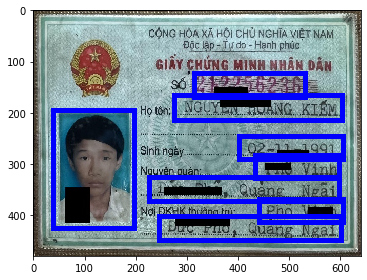

In [ ]:
import os
from PIL import Image
image_path = "/content/image/cutout_0.3/IMG_2477_cutout_0.3.jpg"
file_name = image_path[:-3] + "txt"

im = Image.open(image_path)
width, height = im.size

from skimage import data, io
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
im = Image.open(image_path)

origin_width, origin_height = im.size

fig,ax = plt.subplots(1)
show_img = np.asarray(im)
io.imshow(show_img)


# Create a Rectangle patch
with open(file_name,"r") as f_out:
  lines = f_out.read().splitlines()
  for line in lines:
    component = line.split(" ")
    new_annot = {"x":float(component[1]),"y":float(component[2]),"width":float(component[3]),"height":float(component[4])}
    height = new_annot["height"] 
    width = new_annot["width"] 

    x = new_annot["x"] - (width/2)
    y = new_annot["y"] - (height/2)
    print("x ",x,"y ",y, "width ", width, "height ", height)
    rect = patches.Rectangle((round(x*origin_width),round(y*origin_height)),
                             round(width* origin_width),round(height* origin_height),linewidth=5,edgecolor='b',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()
fig.savefig("result.jpg")

In [ ]:
# import numpy

# def find_coeffs(pa, pb):
#     matrix = []
#     for p1, p2 in zip(pa, pb):
#         matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
#         matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

#     A = numpy.matrix(matrix, dtype=numpy.float)
#     B = numpy.array(pb).reshape(8)

#     res = numpy.dot(numpy.linalg.inv(A.T * A) * A.T, B)
#     return numpy.array(res).reshape(8)

# import sys
# from PIL import Image

# img = Image.open("/content/image/IMG_2477.jpg")
# width, height = img.size
# horizon_shear = -0.3
# vertical_shear = 0
# xshift = abs(horizon_shear) * width
# new_width = width + int(round(xshift))
# # img = img.transform((new_width, height), Image.AFFINE,
# #         (1, m, -xshift if m > 0 else 0, 0, 1, 0), Image.BICUBIC)


# # img.save("IMG_2477.jpg")

# coeffs = find_coeffs([(0, 0), (width, 0), (new_width, height), (xshift, height)],
#         [(0, 0), (width, 0), (width, height), (0, height)]
#         )

# img = img.transform((new_width, height), Image.PERSPECTIVE, coeffs,
#         Image.BICUBIC).save("IMG_2477_revert.jpg")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
